In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn import datasets
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")


**Lectura del Archivo**

1.- Leemos el archivo y le damos un head para ver que la información cargó correctamente.

In [4]:
data= pd.read_csv("hospitalizaciones_train.csv")
data.head(2)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9


2.- Ahora observamos la estructura de los datos y las dimensiones del  dataset :

In [5]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

Observamos que el dataset esta constituido por 41,000 registros y tenemos 15 variables, de las cuales 5 son de caracter cuantitativo (1 float y 4 int) 

3.- Ahora obseervaremos la cantidad de NAs que contiene nuestro dataset

In [6]:
data.isna().sum(axis=0)

Available Extra Rooms in Hospital    0
Department                           0
Ward_Facility_Code                   0
doctor_name                          0
staff_available                      0
patientid                            0
Age                                  0
gender                               0
Type of Admission                    0
Severity of Illness                  0
health_conditions                    0
Visitors with Patient                0
Insurance                            0
Admission_Deposit                    0
Stay (in days)                       0
dtype: int64

<AxesSubplot: >

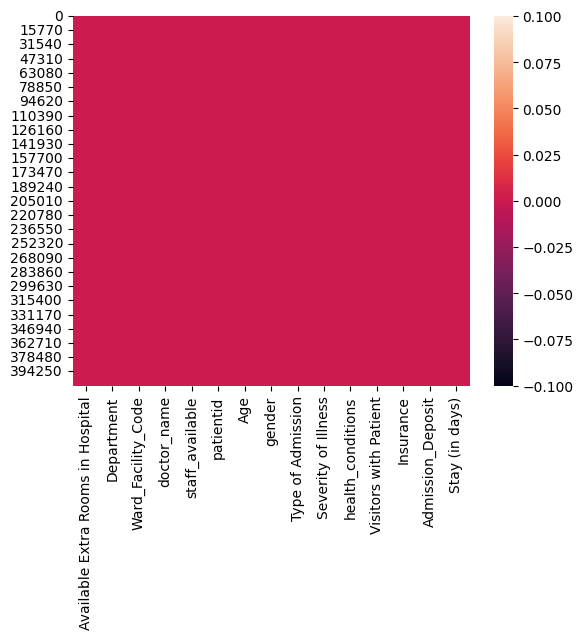

In [7]:
sns.heatmap(data.isnull())

Observamos que no tenemos valores perdidos marcados como NA´s o nulls.

4.- Procederemos a efectuar algunos cambios de nombres en las columnas antes de seguir para facilitarnos las referencias posteriores en el codigo.

In [8]:
data.rename({"Available Extra Rooms in Hospital": "Extra_rooms"}, axis=1, inplace=True)
data.rename({"Type of Admission": "Type_Admission"}, axis=1, inplace=True)
data.rename({"Severity of Illness": "Severity_illness"}, axis=1, inplace=True)
data.rename({"Visitors with Patient": "Visitors_Patient"}, axis=1, inplace=True)
data.rename({"Stay (in days)": "Stay_days"}, axis=1, inplace=True)

5.- Ahora procederemos a construir la variable dependiente dicotómica, antes de hacer una analisis exploratorios de las variables : **" ... se define que un paciente posee estancia hospitalaria prolongada si ha estado hospitalizado más de 8 días."**.
Daremos un head al final para ver que la construcción fue adecuada. De estar todo correcto procederemos a eliminar la columna original.

In [9]:
data["y"]= (data["Stay_days"] > 8 )*1
data.head(3)

,Extra_rooms,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type_Admission,Severity_illness,health_conditions,Visitors_Patient,Insurance,Admission_Deposit,Stay_days,y
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8,0
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9,1
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7,0


In [10]:
data.drop(["Stay_days"], axis= 1,inplace=True)
data.head(1)

,Extra_rooms,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type_Admission,Severity_illness,health_conditions,Visitors_Patient,Insurance,Admission_Deposit,y
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,0


6.- Ahora procederemos a observar si las clases a predecir se encuentran balanceadas, a fin de que nuestro modelo no se sesgue.

In [11]:
data["y"].value_counts()

1    255416
0    154584
Name: y, dtype: int64

<AxesSubplot: xlabel='y', ylabel='count'>

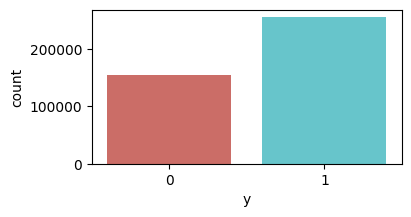

In [12]:
plt.figure(figsize=(4,2))
sns.countplot(x="y", data=data, palette="hls")

Observamos que las clases estan balanceadas. Sino hubiera sido así hubieramos tenido dos caminos : Quitar registros de la clase en exceso o generar registros sintéticos de la clase en falta. En este caso no será necesario.

7.- Ahora empezaremos a observar las variables cuantitativas. A este respecto hay muchas maneras de tener idea de que variables crearán valor al modelo y cuales probablemente no. 

-   A) Matriz de correlaciones
-   B) Observando los promedios muestrales de las variables cuantitativas según las clases de la variable "y".
-   C) Observando el traslape de distribuciones de cada variable según las clases de la variable "y" a través de un plot del dataset que nos brinda python.

7.1.- **Matriz de Correlaciones**

In [13]:
def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    # Arreglamos un pequeño problema de visualización
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

In [14]:
corr=data.corr()
corr

,Extra_rooms,staff_available,patientid,Visitors_Patient,Admission_Deposit,y
Extra_rooms,1.000000,-0.003064,-0.005426,0.071073,-0.050775,0.053894
staff_available,-0.003064,1.000000,-0.000350,0.001444,0.000816,0.002883
patientid,-0.005426,-0.000350,1.000000,-0.006393,0.011602,-0.000532
Visitors_Patient,0.071073,0.001444,-0.006393,1.000000,-0.069566,-0.009529
Admission_Deposit,-0.050775,0.000816,0.011602,-0.069566,1.000000,-0.016650
y,0.053894,0.002883,-0.000532,-0.009529,-0.016650,1.000000


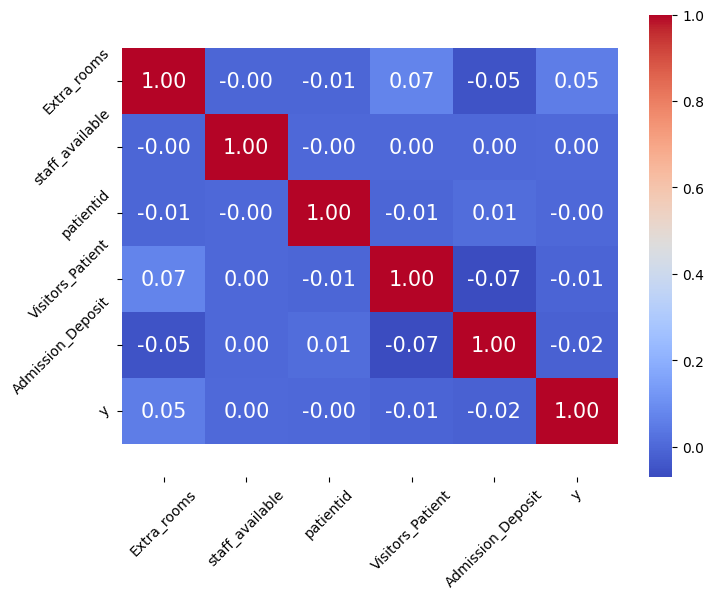

In [14]:
plot_corre_heatmap(corr)

Debemos tener en cuenta que la variable "y" es dicotómica y a pesar de ser numérica (0 ó 1), es una variable cualitativa. Por tanto observar las correlaciones de la variable "y" versus variables cuantitativas no es correcto, este mapa de calor o la matriz numérica nos sirve para observar si existen correlaciones entre los predictores numéricos, en cuyo caso debieramos o juntar los predictores correlacionados o eliminar uno de ellos. En este caso las correlaciones son muy pobres, cercanas a cero. Por tanto los predictores numéricos no correlacionan entre si.

7.2.- **Observando los promedios muestrales de las variables cuantitativas según las clases de la variable "y"**

In [15]:
data.groupby("y").mean()

,Extra_rooms,staff_available,patientid,Visitors_Patient,Admission_Deposit
y,,,,,
0,3.452214,5.009244,63124.427987,3.580047,4745.836775
1,3.752651,5.028029,63078.698406,3.535859,4709.851599


Observamos que las variables cuantitativas a nivel de medias no muestran mucha diferencia agrupadas por las clases de la variable "y"

7.3.- **Observando traslape de distribuciones de cada variable cuantitativa según las clases de la variable "y"**

El proceso demora no es necesario correrlo ya se deja la imagen generada.

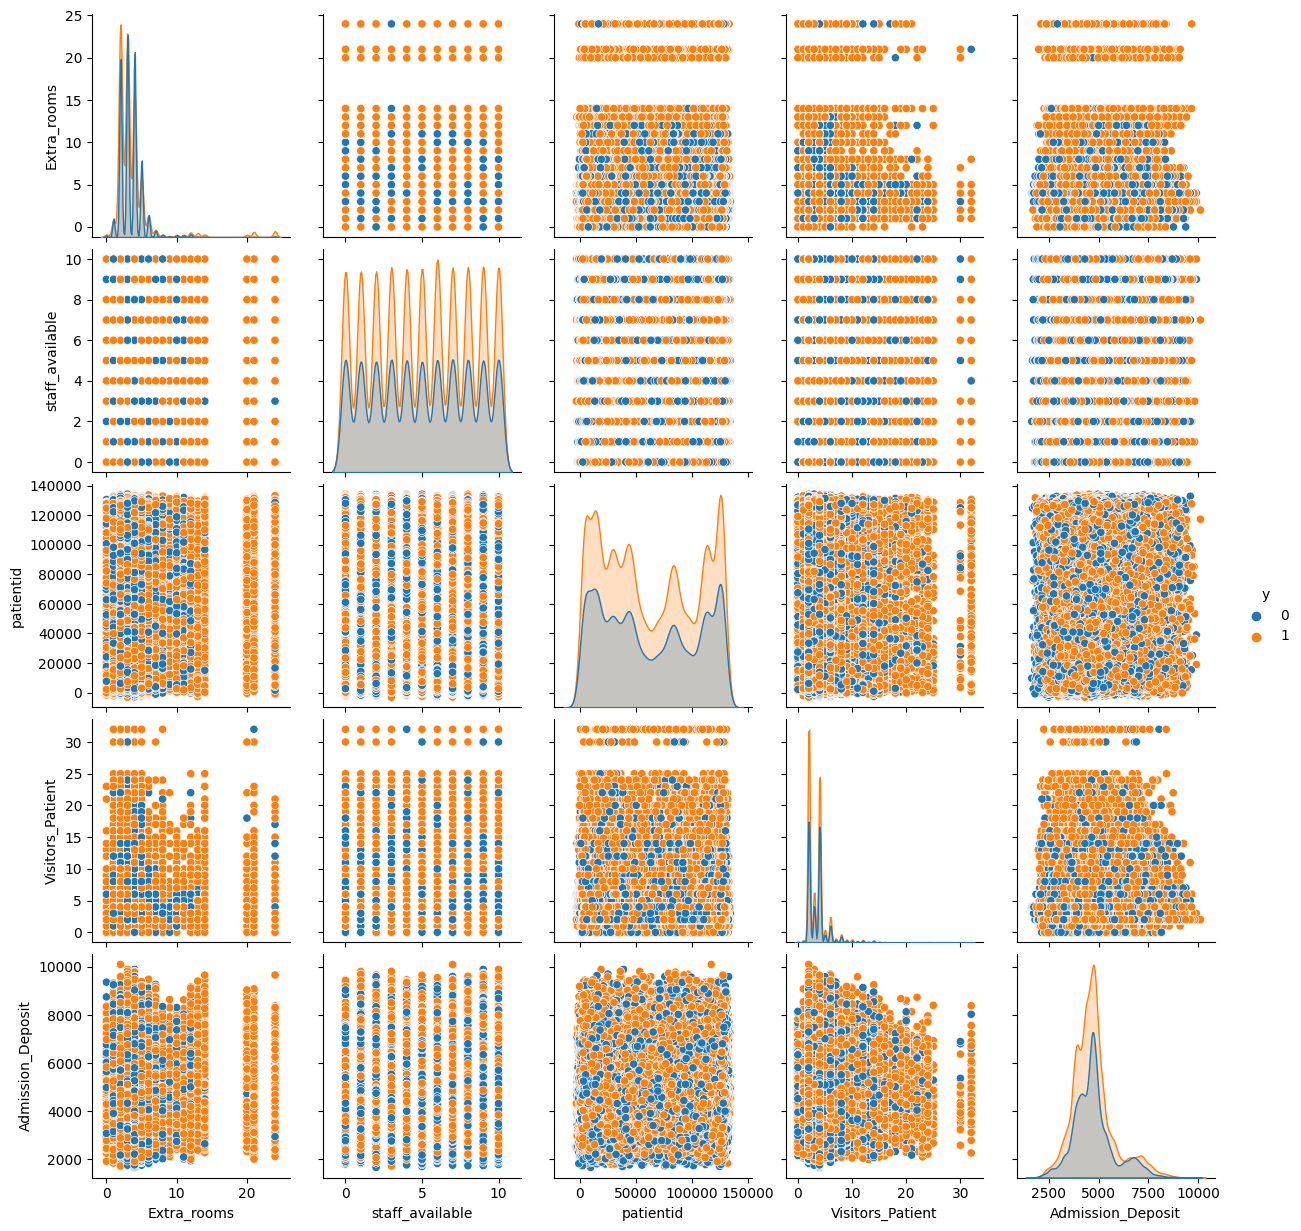

In [59]:
sns.pairplot(data, hue = 'y')
plt.show()

Podemos apreciar que las distribuciones muestrales de las variables cuantitativas para cada clase de la variable "y", se encuentran totalmente sobrepuestas a lo ancho, por tanto no serán muy utiles para ayudarnos a distinguir a que clase (0 o 1) pertenece una observación. En esta caso la conclusión coincide con la observación de las medias en el acápite 7b, que se veian practicamente similares.

8.- Ahora veremos como se comportan las variables categoricas con respecto a las clases de la variable "y". La idea es encontrar que variable presenta cambios cuando cambia la clase de la variable "y".

Cabe destacar que aceptar que una variable tome parte del modelo en esta etapa, no implicará que sea finalmente seleccionada en la etapa final, pues deberemos observar que tan significativa es esa variable para el modelo, por ejemplo en una regresión logistica será a través del pvalor procedente de la prueba de hipotesis a la que será sometido el respectivo coeficiente de la variable que conformará el modelo.

8.1.- **Variable : Department**

La variable "Department", tiene clases como "surgery" o "anesthesia" que muestran una diferencia marcada entre clases de la variable "y". Esta variable nos podría servir para el modelo. Y es completamente logico que un paciente que pase por cirugia o requiera anestesia se mas probable que tenga una estancia mas larga en el nosocomio. Sin embargo Ginecologia o radioterapia son tratamientos mas de caracter ambulatorio, por tanto es coherente que las clases de la variable "y" se encuentren mas niveladas en estas estancias de la variable "Department".

In [16]:
pd.crosstab(data.Department,data.y)

y,0,1
Department,,
TB & Chest disease,658,18167
anesthesia,0,36250
gynecology,127416,154209
radiotherapy,26508,42624
surgery,2,4166


Aplicando la prueba chi-2 de contingencia  para ratificar la asociación existente entre las variables :

In [17]:
chi2_contingency(np.array(pd.crosstab(data.Department,data.y)))

(40662.54350790188,
 0.0,
 4,
 array([[  7097.66780488,  11727.33219512],
        [ 13667.48780488,  22582.51219512],
        [106182.24146341, 175442.75853659],
        [ 26065.12460488,  43066.87539512],
        [  1571.47832195,   2596.52167805]]))

El pvalor es menor a 0.05, por tanto las variables NO son independientes y muestran relación. Sin embargo el test en este caso puede ser un poco inexacto, toda vez que la tabla tene casillas en cero. Pero el apoyo visual en el gráfico siguiente, nos ayuda a cerrar la idea de asociación entre ambas variables.

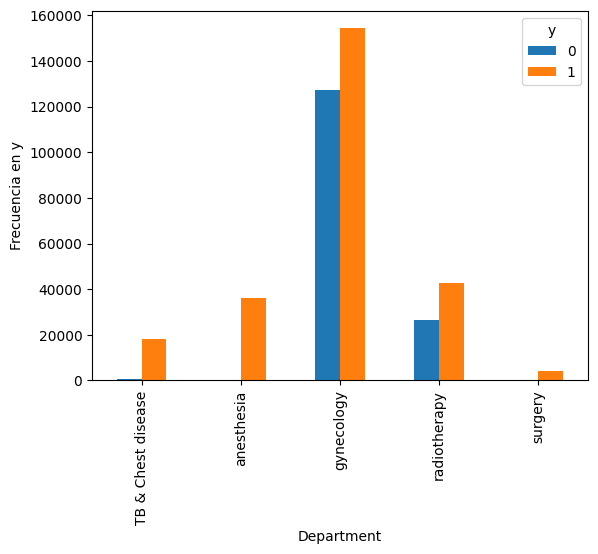

In [18]:
pd.crosstab(data.Department,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("Department")
plt.show()

8.2.- **Variable : Ward_Facility_Code**

In [19]:
pd.crosstab(data.Ward_Facility_Code,data.y)

y,0,1
Ward_Facility_Code,,
A,5700,32512
B,37347,47937
C,2854,9170
D,43576,53828
E,18614,59525
F,46493,52444


Efectuamos una prueba chi2 para ver si hay asociación de "y" respecto a "Ward_Facility_Code".

In [20]:
chi2_contingency(np.array(pd.crosstab(data.Ward_Facility_Code,data.y)))

(22888.944804274757,
 0.0,
 5,
 array([[14407.2288    , 23804.7712    ],
        [32154.98013659, 53129.01986341],
        [ 4533.45857561,  7490.54142439],
        [36724.63399024, 60679.36600976],
        [29461.07116098, 48677.92883902],
        [37302.62733659, 61634.37266341]]))

El pvalor es menor a 0.05, por tanto las variables NO son independientes y muestran relación.

Text(0.5, 0, 'Ward_Facility_Code')

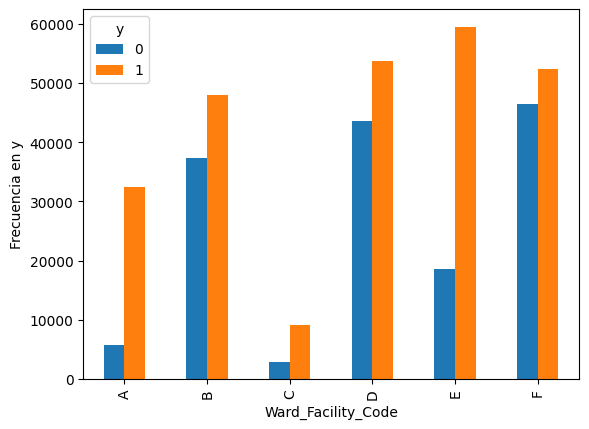

In [21]:
pd.crosstab(data.Ward_Facility_Code,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("Ward_Facility_Code")

Observamos que en las habitaciones con codigos "B", "D" y "F" las clases de la variable "y" estan mas compensadas, es decir no ayudan en distinguir la clase que deseamos. Sin embargo las habitaciones de codigos "A" "C" y "E" muestran que nos podrian crear valor en el modelo. Pero antes debemos ver si efectivamente estamos ganando información para el modelo con esta variable, para lo cual revisemos que relación tienen las variables "Department" y "Ward_Facility_Code"

In [22]:
pd.crosstab(data.Ward_Facility_Code,data.Department)

Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Ward_Facility_Code,,,,,
A,3856,12835,0,17353,4168
B,0,0,85284,0,0
C,1086,3487,0,7451,0
D,0,0,97404,0,0
E,13883,19928,0,44328,0
F,0,0,98937,0,0


Text(0.5, 0, 'Ward_Facility_Code')

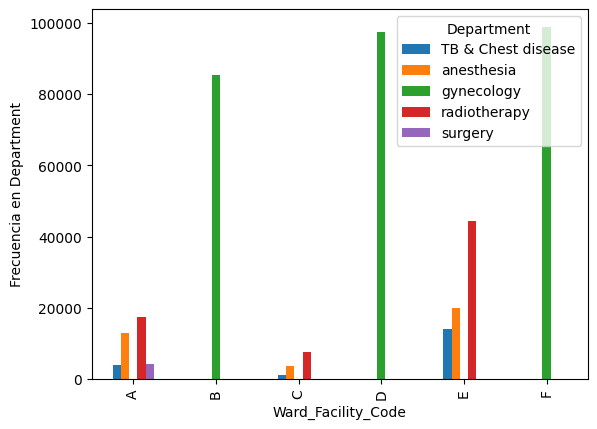

In [23]:
pd.crosstab(data.Ward_Facility_Code,data.Department).plot(kind="bar")
plt.ylabel("Frecuencia en Department")
plt.xlabel("Ward_Facility_Code")

Podemos observar que las habitaciones con codigos "B", "D" y "F" son estrictamente para Ginecología, mientras que los demás codigos se comparten. En este caso esta variable "Ward_Facility_Code" nos brinda casi la misma información que la variable "Department". Por tanto no consideraremos el codigo de la habitación como un predictor del modelo junto con el departamento, posteriormente en las pruebas de modelos se verá cual convendrá más.

8.3.- **Variable : doctor_name**

In [24]:
pd.crosstab(data.doctor_name,data.y)

y,0,1
doctor_name,,
Dr Isaac,1,2980
Dr John,7567,27016
Dr Mark,479,39311
Dr Nathan,28835,33022
Dr Olivia,38746,47450
Dr Sam,19120,30714
Dr Sarah,34830,43887
Dr Simon,1,1186
Dr Sophia,25005,29850


Efectuando la correspondiente prueba de independencia :

In [25]:
chi2_contingency(np.array(pd.crosstab(data.doctor_name,data.y)))

(35685.16939485107,
 0.0,
 8,
 array([[ 1123.93879024,  1857.06120976],
        [13038.97188293, 21544.02811707],
        [15002.18868293, 24787.81131707],
        [23322.20119024, 38534.79880976],
        [32498.83527805, 53697.16472195],
        [18789.11964878, 31044.88035122],
        [29678.99689756, 49038.00310244],
        [  447.53953171,   739.46046829],
        [20682.20809756, 34172.79190244]]))

El pvalor es menor a 0.05, por tanto las variables NO son independientes y muestran relación. Sin embargo el test en este caso puede ser un poco inexacto, toda vez que la tabla tiene casillas en uno. Pero el apoyo visual en el gráfico siguiente, otra vez nos ayuda a cerrar la idea de asociación entre ambas variables.

Text(0.5, 0, 'doctor_name')

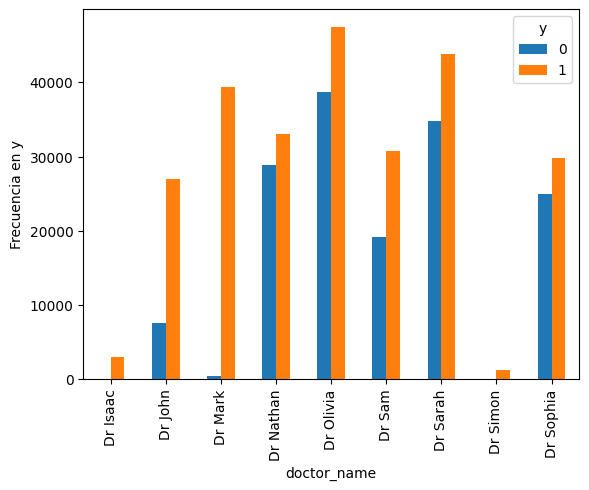

In [26]:
pd.crosstab(data.doctor_name,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("doctor_name")

Pero observemos que :

In [27]:
pd.crosstab(data.doctor_name,data.Department)

Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
doctor_name,,,,,
Dr Isaac,0,0,0,0,2981
Dr John,5229,10056,0,19298,0
Dr Mark,13596,26194,0,0,0
Dr Nathan,0,0,61857,0,0
Dr Olivia,0,0,86196,0,0
Dr Sam,0,0,0,49834,0
Dr Sarah,0,0,78717,0,0
Dr Simon,0,0,0,0,1187
Dr Sophia,0,0,54855,0,0


Ocurre lo mismo que con el item anterior (8B), los nombres de los doctores nos pueden agregar valor al modelo, pero la información que brindan ya nos la da por ejemplo la variable "Department". Las variables estan asociadas, deberemos poner tambien esta variable en la bolsa junto con las variables "Department" y "Ward_Facility_Code" para luego enfrentarlas y ver que ocurre.Se deberá escoger una de ellas.

8.4.- **Variable : Age**

In [28]:
pd.crosstab(data.Age,data.y)

y,0,1
Age,,
0-10,0,2753
11-20,15923,20837
21-30,54566,80463
31-40,52495,54277
41-50,31600,34373
51-60,0,17733
61-70,0,21781
71-80,0,15384
81-90,0,6678


Text(0.5, 0, 'Age')

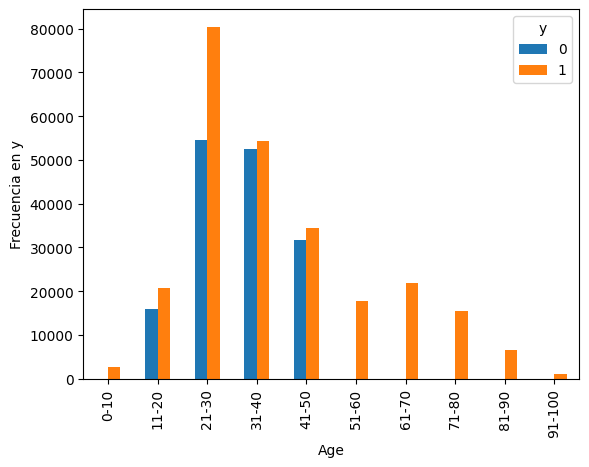

In [29]:
pd.crosstab(data.Age,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("Age")

La edad podría ser un predictor, tenemos clases en la variable "Age" donde se marca una clara diferencia para con las clases de la variable "y", como 0-10, y 51 en adelante.

Prescindiremos de la prueba chi2, pues existen demasiados ceros en la tabla de contingencia.

8.5.- **Variable : gender**

In [30]:
pd.crosstab(data.gender,data.y)

y,0,1
gender,,
Female,131172,168330
Male,19600,73005
Other,3812,14081


Efectuando una vez mas la prueba chi-cuadrado :

In [31]:
chi2_contingency(np.array(pd.crosstab(data.gender,data.y)))

(17566.720692389965,
 0.0,
 2,
 array([[112922.48089756, 186579.51910244],
        [ 34915.24712195,  57689.75287805],
        [  6746.27198049,  11146.72801951]]))

En esta caso la prueba una vez mas es concluyente en la asociación entre "y" y "gender".

Text(0.5, 0, 'gender')

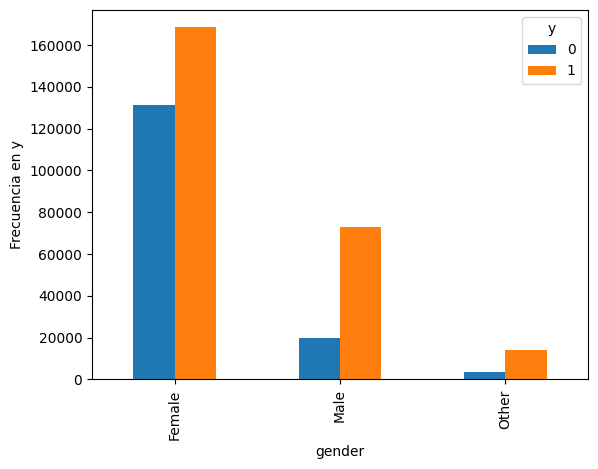

In [32]:
pd.crosstab(data.gender,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("gender")

Observamos que en sexo masculino las diferencias entre clases de la variable "y" son apreciables, no tanto asi en la clase femenina, donde las clases de la variable "y" son más balanceadas.

Sin embargo notamos que la clase "Other" marca también una diferencia. Sin embargo se podria completar algo de la clase "Other" si el paciente visita ("Departement== "ginecology") :

In [33]:
data[(data["gender"]=="Other") & (data["Department"]=="gynecology")]

,Extra_rooms,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type_Admission,Severity_illness,health_conditions,Visitors_Patient,Insurance,Admission_Deposit,y


No hay algo por completar. Por tanto se optará por dejar esta clase tal como está sin completar por la moda.

8.6.- **Variable : Type_Admission**

In [34]:
pd.crosstab(data.Type_Admission,data.y)

y,0,1
Type_Admission,,
Emergency,43094,68280
Trauma,94560,160138
Urgent,16930,26998


In [35]:
chi2_contingency(np.array(pd.crosstab(data.Type_Admission,data.y)))

(95.65347409402082,
 1.6947748596830503e-21,
 2,
 array([[ 41991.80101463,  69382.19898537],
        [ 96029.84300488, 158668.15699512],
        [ 16562.35598049,  27365.64401951]]))

Tambien esta variable esta asociada  "y".

Text(0.5, 0, 'Type_Admission')

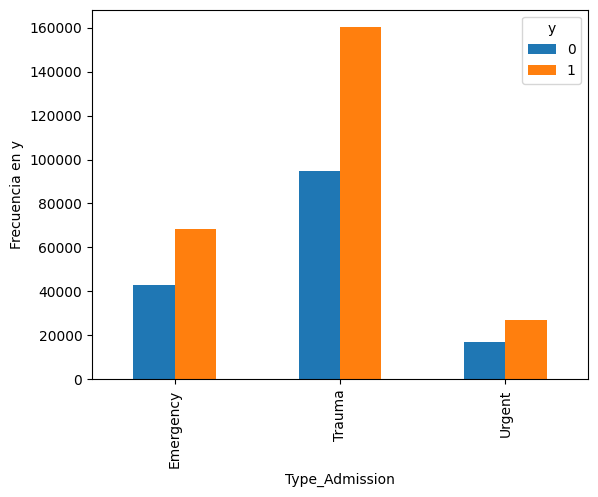

In [36]:
pd.crosstab(data.Type_Admission,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("Type_Admission")

La clase Trauma podria crear una diferencia entre las clases de la varible "y"

In [37]:
pd.crosstab(data.Type_Admission,data.Department)

Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Type_Admission,,,,,
Emergency,3754,6830,79512,20578,700
Trauma,12726,25657,173300,39738,3277
Urgent,2345,3763,28813,8816,191


In [38]:
chi2_contingency(np.array(pd.crosstab(data.Type_Admission,data.Department)))

(3240.6227094456463,
 0.0,
 8,
 array([[  5113.69646341,   9847.09146341,  76501.71402439,
          18779.28626341,   1132.21178537],
        [ 11694.3654878 ,  22519.0304878 , 174949.57134146,
          42945.8100878 ,   2589.22259512],
        [  2016.93804878,   3883.87804878,  30173.71463415,
           7406.90364878,    446.56561951]]))

El test de independencia nos advierte que también hay relación entre "y" con "Type_Admission"

Text(0.5, 0, 'Department')

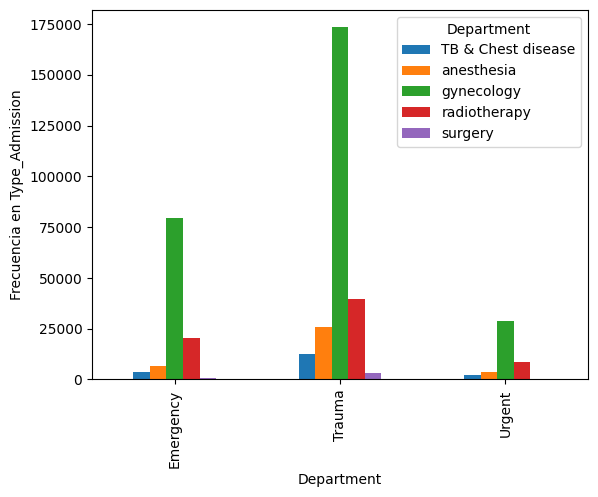

In [39]:
pd.crosstab(data.Type_Admission,data.Department).plot(kind="bar")
plt.ylabel("Frecuencia en Type_Admission")
plt.xlabel("Department")

No observamos gran compenetración entre "Department" y "Type_Admission", puede ser considerada la variable "Type_Admission" dentro de la selección de variables.

8.7.- **Variable : Severity_illness**

In [40]:
pd.crosstab(data.Severity_illness,data.y)

y,0,1
Severity_illness,,
Extreme,26522,44762
Minor,43979,63918
Moderate,84083,146736


In [41]:
chi2_contingency(np.array(pd.crosstab(data.Severity_illness,data.y)))

(596.5600092827495,
 2.875013724138087e-130,
 2,
 array([[ 26876.5020878 ,  44407.4979122 ],
        [ 40680.8532878 ,  67216.1467122 ],
        [ 87026.64462439, 143792.35537561]]))

Pvalor menor a 0.05. Por tanto asociación comprobada.

Text(0.5, 0, 'Severity_illness')

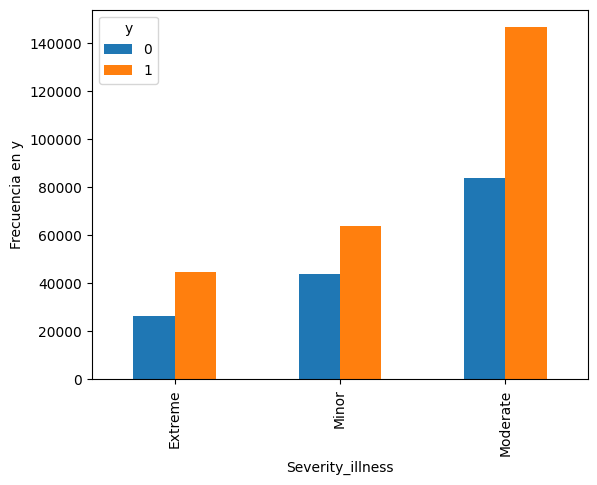

In [42]:
pd.crosstab(data.Severity_illness,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("Severity_illness")

In [43]:
pd.crosstab(data.Severity_illness,data.Department)


Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Severity_illness,,,,,
Extreme,3488,6927,48339,11205,1325
Minor,4539,7488,80660,14777,433
Moderate,10798,21835,152626,43150,2410


La variable "Department" presenta proporciones similares por cada clase de la variable "Severity_illnesss" por tanto no se aparenta una relación al menos sólida entre ellas. Sin embargo el distingo de la clase "y" entre cada instancia de la variable "Severity_illness" no es tan pronunciada. Se verá más adelante si ingresa y cuanto de información nos suma versus la complejidad que añade.

8.8.- **Variable : health_condition**

In [44]:
pd.crosstab(data.health_conditions,data.y)

y,0,1
health_conditions,,
Asthama,18673,31755
Diabetes,22394,36295
Heart disease,7996,13261
High Blood Pressure,23714,40375
None,52462,84740
Other,29345,48990


Text(0.5, 0, 'healths_condition')

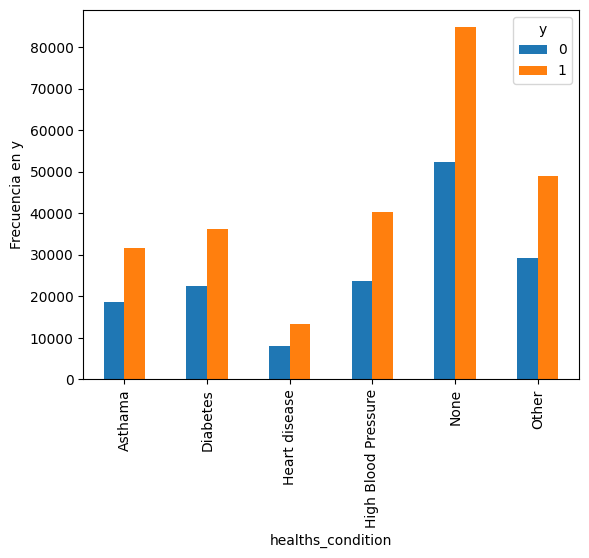

In [45]:
pd.crosstab(data.health_conditions,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("healths_condition")

En esta caso falta del atributo "health_conditions" 137,202 registros es decir un tercio del dataset. Completar los valores desconocidos por la moda es no conveniente toda vez qe las clases están muy balanceadas. Otro camino es completar los datos posibles, contrastando con los médicos y el departmento en que laboran: 

In [46]:
pd.crosstab(data.health_conditions,data.doctor_name)

doctor_name,Dr Isaac,Dr John,Dr Mark,Dr Nathan,Dr Olivia,Dr Sam,Dr Sarah,Dr Simon,Dr Sophia
health_conditions,,,,,,,,,
Asthama,323,4657,4721,0,0,5851,34708,168,0
Diabetes,432,5313,5493,0,0,7030,0,197,40224
Heart disease,192,56,2801,0,0,3574,0,3,14631
High Blood Pressure,469,5210,6383,0,0,7823,44009,195,0
None,936,12729,12725,39409,54830,16149,0,424,0
Other,629,6618,7667,22448,31366,9407,0,200,0


In [47]:
pd.crosstab(data.Department,data.doctor_name)

doctor_name,Dr Isaac,Dr John,Dr Mark,Dr Nathan,Dr Olivia,Dr Sam,Dr Sarah,Dr Simon,Dr Sophia
Department,,,,,,,,,
TB & Chest disease,0,5229,13596,0,0,0,0,0,0
anesthesia,0,10056,26194,0,0,0,0,0,0
gynecology,0,0,0,61857,86196,0,78717,0,54855
radiotherapy,0,19298,0,0,0,49834,0,0,0
surgery,2981,0,0,0,0,0,0,1187,0


Observamos que "Dr Nathan" y "Dr Olivia" y "Dr Sarah" con valores en None en el atributo "health_conditions" solo atienden ginecologia, es posible completar algo de información, pero si razonamos mejor, veremos que al completar esta información según los nombres de los doctores, existe asociación entre las variables, por lo que no se considerará en el modelo la variable "health_conditions".

8.9.- **Variable : Insurance**

In [48]:
pd.crosstab(data.Insurance,data.y)

y,0,1
Insurance,,
No,26125,43376
Yes,128459,212040


In [49]:
chi2_contingency(np.array(pd.crosstab(data.Insurance,data.y)))

(0.45744135087549403,
 0.4988221951889673,
 1,
 array([[ 26204.25020488,  43296.74979512],
        [128379.74979512, 212119.25020488]]))

El pvalor en esta caso sale de 0.4988, por tanto "Insurance" no esta relacionada con "y". Definitivamente no estará contemplada dentro de la lista de variables candidatas para alún modelo.

Text(0.5, 0, 'Insurance')

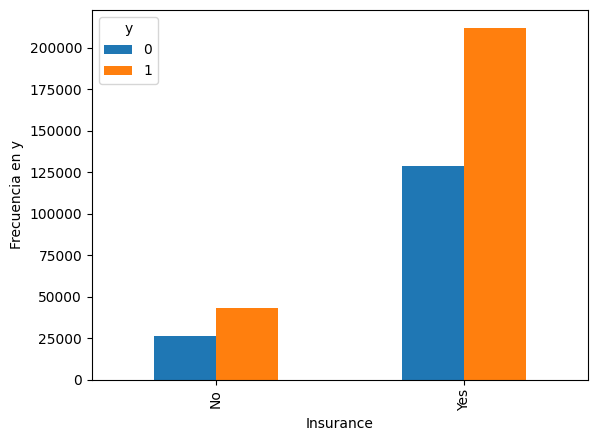

In [50]:
pd.crosstab(data.Insurance,data.y).plot(kind="bar")
plt.ylabel("Frecuencia en y")
plt.xlabel("Insurance")

9.- **Conformacion de los Dataframes y datos de Test y Train**

Como se vio en la sección 8 (análisis de variables cualitativas), las variables "Department", "doctor_name" y "Ward_Facility_code" retornan información muy similar al modelo, por lo que usaremos "doctor_name" de entre las tres citadas.

In [79]:
data.head(1)

,Extra_rooms,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type_Admission,Severity_illness,health_conditions,Visitors_Patient,Insurance,Admission_Deposit,y
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,0


***Modelo operando con las variables :***

A continuación se encontrarán tres bloques de codigo titulados. Se corrieron modelos con las dos primeras formas de tratamiento para codificar variables cualitativas, la primera forma fue añadiendo dummies y la segunda forma fue codificando con One Hot Encoder y estandarizando. Solo correr uno de los dos primeros bloques segun se desee para generar las variables de input a los modelos siguientes. EL 3er bloque es exclusivo para la regresión Logistica Recursiva.

En el 3er bloque se consideró la fuerza bruta para considerar todas las variables en la regresión Logistica, pero con el optimizador **RFECV**, el cual va quitando variables de tal manera que el modelo obtenga las mejores métricas.

Modalidad con get_dummies :

In [200]:
dfDep=data.copy()
from sklearn.model_selection import train_test_split

X = dfDep[["doctor_name","Type_Admission","Severity_illness","Age","Visitors_Patient","Admission_Deposit"]]
X["Admission_Deposit"]=X["Admission_Deposit"]/1000
X= pd.get_dummies(X,drop_first=True)

y = dfDep["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2022)



Modalidad con One Hot encoder

In [249]:
from sklearn import preprocessing
encode_bin = preprocessing.LabelEncoder()
#X2 = dfDep[["doctor_name","Type_Admission","Severity_illness","Age","Visitors_Patient","Admission_Deposit"]]
X2 = dfDep[["doctor_name","Department","gender","Age"]]
X2["doctor_name"]= encode_bin.fit_transform(X2["doctor_name"])
#X2["Type_Admission"]= encode_bin.fit_transform(X2["Type_Admission"])
#X2["Severity_illness"]= encode_bin.fit_transform(X2["Severity_illness"])
X2["Age"]= encode_bin.fit_transform(X2["Age"])
X2["Department"]= encode_bin.fit_transform(X2["Department"])                #nueva
X2["gender"]= encode_bin.fit_transform(X2["gender"])                        #nueva
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X2_st=scaler.fit_transform(X2)


y = dfDep["y"]

X_train, X_test, y_train, y_test = train_test_split(X2_st, y, test_size=0.30, random_state=2022)

Generación de todas las variables para que el optimizador de variables aplicado a la regresión Logistica escoja :

In [251]:
from sklearn import preprocessing
encode_bin = preprocessing.LabelEncoder()
Xr = data.copy()
Xr["doctor_name"]= encode_bin.fit_transform(Xr["doctor_name"])
Xr["Type_Admission"]= encode_bin.fit_transform(Xr["Type_Admission"])
Xr["Severity_illness"]= encode_bin.fit_transform(Xr["Severity_illness"])
Xr["gender"]= encode_bin.fit_transform(Xr["gender"])
Xr["Age"]= encode_bin.fit_transform(Xr["Age"])
Xr["Department"]= encode_bin.fit_transform(Xr["Department"])
Xr["Insurance"]= encode_bin.fit_transform(Xr["Insurance"])
Xr["Ward_Facility_Code"]= encode_bin.fit_transform(Xr["Ward_Facility_Code"])
y = Xr["y"]

Xr.drop(["patientid","health_conditions","y"],axis=1,inplace=True)


from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Xr_st=scaler.fit_transform(Xr)




X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr_st, y, test_size=0.30, random_state=2022)

10.- **Entrenamientos de Modelos y Predicción**

In [204]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,f1_score,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import joblib

10.1.1.- **REGRESION LOGISTICA**

In [143]:
from sklearn import linear_model

In [252]:
logit = linear_model.LogisticRegression()
logit.fit(X_train,y_train)
ypred = logit.predict(X_test)

accuracy_score : = 0.5883
Recall_score : = 0.8231
F1_score =  0.7134


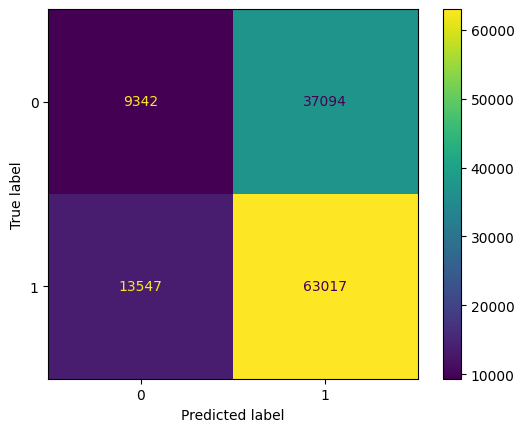

In [253]:
cfd = ConfusionMatrixDisplay(confusion_matrix(y_test,ypred,labels=[0,1]))
prd = recall_score(y_test, ypred, average= None)
print("accuracy_score : =",round(accuracy_score(y_test, ypred),4))
print("Recall_score : =",round(recall_score(y_test, ypred),4))
print("F1_score = ",round(f1_score(y_test,ypred),4))
cfd.plot()
plt.show()

Las 100 iteraciones con validación cruzada nos dio un acuraccy promedio de  : 0.5877


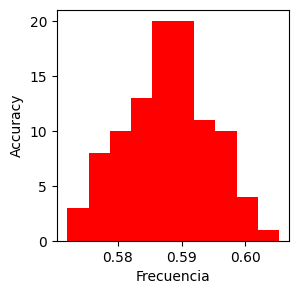

In [254]:
cv=100
logit_scores = cross_val_score(logit, X_train, y_train, cv=100)
print(f"Las {cv} iteraciones con validación cruzada nos dio un acuraccy promedio de  : {round(logit_scores.mean(),4)}")

plt.figure(figsize=(3,3))
plt.hist(logit_scores, color = "red")
plt.ylabel("Accuracy")
plt.xlabel("Frecuencia")
plt.show()

Calculamos las probabilidades de que cada observación pertenezca a la clase y = 1 :

In [150]:
coef = [logit.coef_[0][0],logit.coef_[0][1],logit.coef_[0][2],logit.coef_[0][3],logit.coef_[0][4],logit.coef_[0][5]]

coef = np.array(coef)

Xmat = np.array(X_test)
probs = []
for j,k in enumerate(y_test):
    e = np.exp(sum(coef*Xmat[j])+logit.intercept_[0])
    p = e/(1+e)
    probs.append(p)

probs = np.array(probs)


Ahora procedemos a iterar las probabilidades de corte y segun ese valor vamos calculando los ratios de : sensibilidad, y de : 1- especificidad, para luego dibujar la curva ROC :

In [151]:
arreglo = np.zeros(len(y_test)*3).reshape(len(y_test),3)
g=0
for probi_corte in np.linspace(0,1,100):
    g+=1
    PPRP=0 #PREDICHOS POSITIVOS REALES POSITIVOS
    PNRN=0 #PREDICHOS NEGATIVOS REALES NEGATIVOS
    for j,k in enumerate(y_test):
        if probi_corte>probs[j]:
            if k == 0:
                PNRN+=1
        else:
            if k == 1:
                PPRP+=1
    TPR = PPRP/sum(y_test)
    TNR = PNRN/(len(y_test)-sum(y_test))
    arreglo[g,0]=probi_corte
    arreglo[g,1]=TPR
    arreglo[g,2]=1-TNR
arreglo = pd.DataFrame(arreglo) 
arreglo.columns=["Probabilidad","Sensibilidad","1-Especificidad"]

Dibujamos la curva ROC :

In [152]:
from sklearn.metrics import roc_curve,auc
FPR, TPR, _ = roc_curve(y_true=y_test,y_score=ypred)
roc_auc = auc(x=FPR, y = TPR)
roc_auc

0.5196426538341898

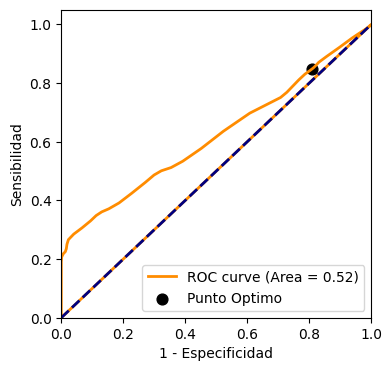

In [153]:
plt.figure(figsize=(4,4))
plt.plot(arreglo["1-Especificidad"],arreglo["Sensibilidad"], color = 'darkorange', lw=2, label = "ROC curve (Area = %0.2f)" % roc_auc)

plt.plot([0,1],[0,1], color = "navy", lw=2,linestyle = "--")
plt.scatter([1-round(prd[0],4)],[round(prd[1],4)], color = "black", s=60,label="Punto Optimo")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.ylabel("Sensibilidad")
plt.xlabel("1 - Especificidad")
plt.legend(loc="lower right")
plt.show()

Poca Area sobre la curva ROC el modelo no se tomará en cuenta para el ensamble final.

10.1.2.-**REGRESION LOGISTICA RECURSIVA**

In [209]:
from sklearn.feature_selection import RFECV
estimador = linear_model.LogisticRegression()
selector=RFECV(estimador,step=1,cv=5)
selector.fit(X_trainr,y_trainr)
selector.support_

array([False,  True, False, False, False,  True, False, False, False,
       False, False, False])

In [210]:
ypred_RFECV=selector.predict(X_testr)

accuracy_score : = 0.6187
Recall_score : = 0.8686
F1_score =  0.7393


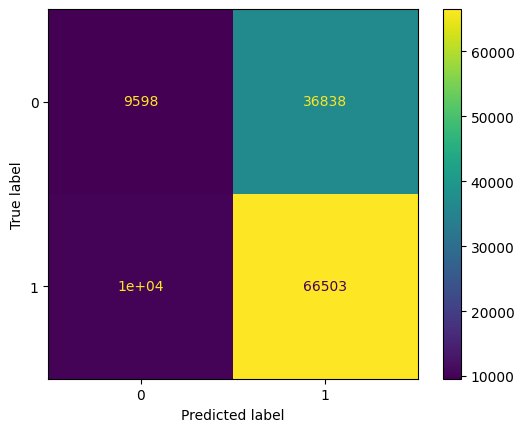

In [211]:
cfd = ConfusionMatrixDisplay(confusion_matrix(y_testr,ypred_RFECV,labels=[0,1]))
prd = recall_score(y_testr, ypred_RFECV, average= None)
print("accuracy_score : =",round(accuracy_score(y_testr, ypred_RFECV),4))
print("Recall_score : =",round(recall_score(y_testr, ypred_RFECV),4))
print("F1_score = ",round(f1_score(y_testr,ypred_RFECV),4))
cfd.plot()
plt.show()

10.2.- **RANDOM FOREST**

Empezaremos desde este modelo a usar optimizadores de hiperparametros :

In [196]:
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {"n_estimators": n_estimators,
               "max_features": max_features,
               "max_depth": max_depth,
               "min_samples_split": min_samples_split,
               "min_samples_leaf": min_samples_leaf,
               "bootstrap": bootstrap}


Entrenamos el modelo y predecimos :

In [ ]:
RF = RandomForestClassifier()

RF_mod = GridSearchCV(RF, param_grid=param_grid, cv=5)
RF_mod.fit(X_train,y_train)
joblib.dump(RF_mod,"RF.joblib")
ypred_rf = RF_mod.predict(X_test)

Ahora calculamos los  ratios de performance del modelo para los datos de test.

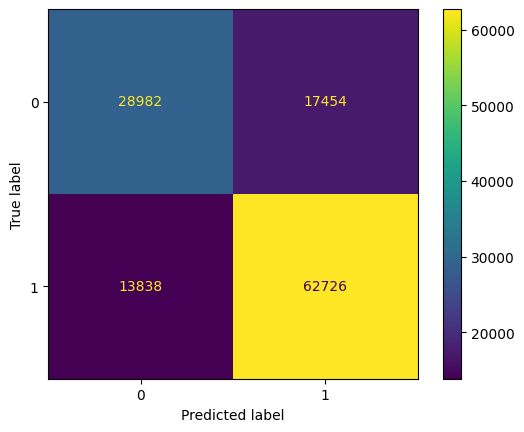

In [185]:
cfrf = ConfusionMatrixDisplay(confusion_matrix(y_test,ypred_rf,labels=[0,1]))
cfrf.plot()
plt.show()

In [186]:
c=confusion_matrix(y_test,ypred_rf)
print(f"accuracy Random Forest = {c.diagonal().sum()/c.sum()}")
print(f"especificidad Random Forest = {c[0][0]/c[0].sum()}")
print(f"sensibilidad Random Forest = {c[1][1]/c[1].sum()}")

accuracy Random Forest = 0.7455934959349594
especificidad Random Forest = 0.6241278318545955
sensibilidad Random Forest = 0.8192623164933911


10.3.- **KNN**

Llego el turno de K Nearest Neighbours.

Usaremos grid-search para optimizar hiperparametros en este modelo :

In [191]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier() #Instanciamos el objeto de la clase
#Creamos grilla de opciones
param_grid = {"n_neighbors":np.arange(1, 20),
              "weights": ['uniform', 'distance'], 
              "leaf_size":[1,3,5,7,10],
              "algorithm":['auto', 'kd_tree']}

# Le pasamos la grilla que creamos
knn_mod = GridSearchCV(knn, param_grid=param_grid, cv=5)

Empezamos a entrenar al modelo (este proceso tarda aproximadamente 155 min)

In [192]:
knn_mod.fit(X=X_train,y=y_train)
joblib.dump(knn_mod,"knn.joblib")

['knn.joblib']

Procedemos a predecir :

In [194]:
ypred_knn=knn_mod.predict(X_test)

Emitimos métricas :

In [195]:
c=confusion_matrix(y_test,ypred_knn)
print(f"accuracy Knn = {c.diagonal().sum()/c.sum()}")
print(f"especificidad Knn = {c[0][0]/c[0].sum()}")
print(f"sensibilidad Knn = {c[1][1]/c[1].sum()}")

accuracy Knn = 0.7334146341463414
especificidad Knn = 0.6231802911534154
sensibilidad Knn = 0.8002716681469098


10.6.- **ARBOL DE CLASIFICACION**

In [260]:
from sklearn import tree

#Creamos grilla de opciones
param_grid = {"max_depth":np.arange(1, 20),
              "splitter":["best", "random"],
              "max_features":[1,2,3,4,5],
              "criterion": ["gini", "entropy", "log_loss"], 
              "min_samples_split":np.arange(2, 20),
              "min_samples_leaf":np.arange(2, 20)}

arbol = tree.DecisionTreeClassifier()
tree_mod = GridSearchCV(arbol, param_grid=param_grid, cv=5)


In [261]:
tree_mod.fit(X=X_train,y=y_train)
joblib.dump(tree_mod,"knn.joblib")

Prediccion y envio de metricas

In [ ]:
ypred_tree=tree_mod.predict(X_test)

c=confusion_matrix(y_test,ypred_tree)
print(f"accuracy Tree = {c.diagonal().sum()/c.sum()}")
print(f"especificidad Tree = {c[0][0]/c[0].sum()}")
print(f"sensibilidad Tree = {c[1][1]/c[1].sum()}")

10.5.- **REDES NEURONALES**

En este modelo una grilla hubiera sido ideal, pero por cuestiones de procesamiento y tiempo no la gestionamos como en los modelos anteriores.

In [212]:
features = np.array(X_train)
target = np.array(y_train)

Formando las capas de neuronas :

In [213]:
import tensorflow as tf
capaEntrada = tf.keras.layers.Dense(units=6,input_shape=[6])
capaOculta = tf.keras.layers.Dense(units = 12,activation="relu")
capaSalida = tf.keras.layers.Dense(units=1,activation="sigmoid")

In [214]:
modelo = tf.keras.Sequential([capaEntrada,capaOculta,capaSalida])
modelo.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,weight_decay=1e-6,nesterov=True,),
metrics=["Recall"],loss="categorical_crossentropy")

Inicio del entrenamiento del modelo (Duracion de un aproximado de 90 minutos)

In [ ]:

print("Iniciando el entrenamiento del modelo...")
historial=modelo.fit(features,target,epochs=1000,verbose=False)
print("Modelo entrenado!")
joblib.dump(modelo,"modelo_nn.joblib")

Viendo la matriz de confusión y las metricas sobre el data de test :

In [83]:
ypred_nn=modelo.predict(X_test)

3844/3844 [==============================] - 4s 931us/step


In [89]:
ypred_nn

array([[0.45025176],
       [0.4180072 ],
       [1.0308195 ],
       ...,
       [0.7003667 ],
       [0.6039801 ],
       [0.4662371 ]], dtype=float32)

In [101]:
arreglo = np.zeros(len(y_test)*3).reshape(len(y_test),3)
g=0
for probi_corte in np.linspace(0,1,100):
    g+=1
    PPRP=0 #PREDICHOS POSITIVOS REALES POSITIVOS
    PNRN=0 #PREDICHOS NEGATIVOS REALES NEGATIVOS
    for j,k in enumerate(y_test):
        if probi_corte>ypred_nn[j]:
            if k == 0:
                PNRN+=1
        else:
            if k == 1:
                PPRP+=1
    TPR = PPRP/sum(y_test)
    TNR = PNRN/(len(y_test)-sum(y_test))
    arreglo[g,0]=probi_corte
    arreglo[g,1]=TPR
    arreglo[g,2]=1-TNR
arreglo = pd.DataFrame(arreglo) 
arreglo.columns=["Probabilidad","Sensibilidad","1-Especificidad"]

In [144]:
arreglo[25:]

,Probabilidad,Sensibilidad,1-Especificidad
25,0.242424,1.000000,0.992506
26,0.252525,0.997610,0.989771
27,0.262626,0.996944,0.986799
28,0.272727,0.996944,0.974029
29,0.282828,0.996944,0.972435
...,...,...,...
122995,0.000000,0.000000,0.000000
122996,0.000000,0.000000,0.000000
122997,0.000000,0.000000,0.000000
122998,0.000000,0.000000,0.000000


Tomaremos como umbral de corte 0.25

In [145]:
ypred_nn_int= (ypred_nn > 0.25 )*1

In [94]:
FPR, TPR, _ = roc_curve(y_true=y_test,y_score=ypred_nn)
roc_auc = auc(x=FPR, y = TPR)
roc_auc

0.6829824065546481

In [148]:
c=confusion_matrix(y_test,ypred_nn_int)
print(f"accuracy Neural Network = {c.diagonal().sum()/c.sum()}")
print(f"especificidad Neural Network = {c[0][0]/c[0].sum()}")
print(f"sensibilidad Neural Network = {c[1][1]/c[1].sum()}")

accuracy Neural Network = 0.6253008130081301
especificidad Neural Network = 0.007494185545697304
sensibilidad Neural Network = 1.0


11.- **ENSAMBLE HARD VOTING**

Luego de haber visto varios modelos, armaremos un ensamble tipo voting con los siguientes modelos : Regresion Logistica Recursiva, Random Forest y KNN.

In [228]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(estimators=[("rf", RF_mod),
                                               ("kn", knn_mod),
                                               ("tree",tree_mod)],
                                   voting='hard')

Entrenamos al ensamble y hacemos la predicción sobre los datos del test :

In [ ]:
voting_clf_hard.fit(X_train, y_train)
y_pred_e = voting_clf_hard.predict(X_test)

Viendo la matriz de confusión y las estadisticas :

In [ ]:
c=confusion_matrix(y_test,y_pred_e)
print(f"accuracy ensamble = {c.diagonal().sum()/c.sum()}")
print(f"especificidad ensamble = {c[0][0]/c[0].sum()}")
print(f"sensibilidad ensamble = {c[1][1]/c[1].sum()}")

Aplicando finalmente validación cruzada :

In [ ]:
cv=100
en_scores = cross_val_score(voting_clf_hard, X_train, y_train, cv=100)
print(f"Las {cv} iteraciones con validación cruzada nos dio un acuraccy promedio de  : {round(en_scores.mean(),4)}")

plt.figure(figsize=(3,3))
plt.hist(en_scores, color = "brown")
plt.ylabel("Accuracy")
plt.xlabel("Frecuencia")
plt.show()

12.- **GENERANDO INTENTOS PARA EL DATATHON**

Leyendo el archivo de test real :

Este primer bloque se usa si se usara la data modelada con dummies :

In [220]:
data2= pd.read_csv("hospitalizaciones_test.csv")
data2.rename({"Available Extra Rooms in Hospital": "Extra_rooms"}, axis=1, inplace=True)
data2.rename({"Type of Admission": "Type_Admission"}, axis=1, inplace=True)
data2.rename({"Severity of Illness": "Severity_illness"}, axis=1, inplace=True)
data2.rename({"Visitors with Patient": "Visitors_Patient"}, axis=1, inplace=True)
data2.rename({"Stay (in days)": "Stay_days"}, axis=1, inplace=True)
Xfinal = data2[["doctor_name","Type_Admission","Severity_illness","Age","Visitors_Patient","Admission_Deposit"]]
Xfinal["Admission_Deposit"]=X["Admission_Deposit"]/1000
Xfinal= pd.get_dummies(X,drop_first=True)

Este segundo bloque se usa si se genera ka data con One hot encoder y standard scaler :

In [221]:
encode_bin = preprocessing.LabelEncoder()
Xfinal = dfDep[["doctor_name","Type_Admission","Severity_illness","Age","Visitors_Patient","Admission_Deposit"]]
Xfinal["doctor_name"]= encode_bin.fit_transform(Xfinal["doctor_name"])
Xfinal["Type_Admission"]= encode_bin.fit_transform(Xfinal["Type_Admission"])
Xfinal["Severity_illness"]= encode_bin.fit_transform(Xfinal["Severity_illness"])
Xfinal["Age"]= encode_bin.fit_transform(Xfinal["Age"])

scaler=StandardScaler()
Xfinal_st=scaler.fit_transform(Xfinal)

Este tercer bloque solo es para la regresión recursiva :

In [223]:
encode_bin = preprocessing.LabelEncoder()
Xf = data2.copy()
Xf["doctor_name"]= encode_bin.fit_transform(Xf["doctor_name"])
Xf["Type_Admission"]= encode_bin.fit_transform(Xf["Type_Admission"])
Xf["Severity_illness"]= encode_bin.fit_transform(Xf["Severity_illness"])
Xf["gender"]= encode_bin.fit_transform(Xf["gender"])
Xf["Age"]= encode_bin.fit_transform(Xf["Age"])
Xf["Department"]= encode_bin.fit_transform(Xf["Department"])
Xf["Insurance"]= encode_bin.fit_transform(Xf["Insurance"])
Xf["Ward_Facility_Code"]= encode_bin.fit_transform(Xf["Ward_Facility_Code"])
Xf.drop(["patientid","health_conditions"],axis=1,inplace=True)


from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
Xf_st=scaler.fit_transform(Xf)

Generando intentos "alone" :

In [ ]:
#TREE ALONE
ypred_final_tree=tree_mod.predict(Xfinal_st)
TREE_csv=pd.DataFrame(ypred_final_tree)
TREE_csv.columns=["pred"]
TREE_csv.to_csv("ricardotalavera.csv", index = False)

In [102]:
#RANDOM FOREST ALONE
ypred_final_rf=RF_mod.predict(Xfinal_st)
RF_csv=pd.DataFrame(ypred_final_rf)
RF_csv.columns=["pred"]
RF_csv.to_csv("ricardotalavera.csv", index = False)

In [218]:
# KNN ALONE
ypred_final_knn=knn_mod.predict(Xfinal_st)
KNN_csv=pd.DataFrame(ypred_final_knn)
KNN_csv.columns=["pred"]
KNN_csv.to_csv("ricardotalavera.csv", index = False)

In [227]:
#REGRESION LOGISTICA RECURSIVA ALONE
ypred_final_log=selector.predict(Xf_st)
LOGIR_csv=pd.DataFrame(ypred_final_log)
LOGIR_csv.columns=["pred"]
LOGIR_csv.to_csv("ricardotalavera.csv", index = False)

Generando intento con ensamble

In [ ]:
#ENSAMBLE
ypred_ensamble=voting_clf_hard.predict(Xfinal)
VOTING_csv=pd.DataFrame(ypred_ensamble)
VOTING_csv.columns=["pred"]
VOTING_csv.to_csv("ricardotalavera.csv", index = False)

12.- **PIPELINE**

In [231]:
from sklearn.pipeline import Pipeline


In [240]:

pipe_logit = Pipeline([("scl",StandardScaler()),
                    ("logit",linear_model.LogisticRegression())])

pipe_knn = Pipeline([("scl",StandardScaler()),
                    ("knn",KNeighborsClassifier())])

pipe_tree = Pipeline([("scl",StandardScaler()),
                    ("tree",tree.DecisionTreeClassifier())])

				

pipelines=[pipe_logit, pipe_knn, pipe_tree]

pipe_dict = {0: "Regresión Logistica", 1: "K Nearest Neighbours", 2: "Arbol de Clasificación"}

for pipe in pipelines:
    pipe.fit(X_train,y_train)

for idx, val in enumerate(pipelines):
	print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identificamos el mejor modelo para el set de testeo

best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	if val.score(X_test, y_test) > best_acc:
		best_acc = val.score(X_test, y_test)
		best_pipe = val
		best_clf = idx
print('Modelo con el mejor accuracy: %s' % pipe_dict[best_clf])

joblib.dump(best_pipe, 'Mejor_pipeline.pkl', compress=1)
print('Pipeline de %s guardado a archivo' % pipe_dict[best_clf])


regresión Logistica pipeline accuracy en test: 0.600
K Nearest Neighbours pipeline accuracy en test: 0.731
Modelo con el mejor accuracy: K Nearest Neighbours
Pipeline de K Nearest Neighbours guardado a archivo
